In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rio

from shapely import Point
import math as math

import pandas as pd
from pathlib import Path
from pystac_client import Client
import folium

from src.utils import SentinelDownloader

root = Path.cwd()

In [ ]:
pts = gpd.read_file(root / 'beech_stands' / 'Points.shp' )
pts = pts.to_crs(26918)
# remove first 4 rows
pts2 = pts.loc[4:,]

# make separate species and dbh columns
pts2['species'] = [x[0] for x in pts2.Name.str.split('dbh')]
pts2['dbh'] = [x[-1] for x in pts2.Name.str.split('dbh')]
pts2 = pts2.drop('Name',axis=1)

# make separate beech and nonbeech gdf
pts2['species'] = pts2.species.str.strip()
beech_pts = pts2.loc[pts2.species=='beech'].copy()
beech_pts.shape
beech_pts['index'] = np.arange(0,len(beech_pts))

nonbeech_pts = pts2.loc[pts2.species!='beech'].copy()
nonbeech_pts.shape
nonbeech_pts = nonbeech_pts.reset_index()

# define 100m buffers for each cluster of pointss
pecoy_buffer = beech_pts.iloc[27:28,].copy().buffer(100)
roundtop_buffer = beech_pts.iloc[54:55,].copy().buffer(100)
visitors_buffer = beech_pts.iloc[66:67,].copy().buffer(100)

polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
polys = polys.reset_index()

In [4]:
polys

index             Name Description  \
0      0    beech stand 1               
1      1    beech stand 2               
2      2    beech stand 3               
3      3    beech stand 4               
4      4  non-beech stand               
5      5  non-beech stand               
6      6  non-beech stand               
7      7  non-beech stand               

                                            geometry  
0  POLYGON Z ((-74.09931 42.15295 0, -74.09929 42...  
1  POLYGON Z ((-74.12421 42.14628 0, -74.12418 42...  
2  POLYGON Z ((-74.12545 42.14641 0, -74.12527 42...  
3  POLYGON Z ((-74.26808 42.02906 0, -74.26813 42...  
4  POLYGON Z ((-74.12554 42.14627 0, -74.12545 42...  
5  POLYGON Z ((-74.09886 42.15326 0, -74.09894 42...  
6  POLYGON Z ((-74.12403 42.14629 0, -74.12391 42...  
7  POLYGON Z ((-74.2676 42.02924 0, -74.26743 42....

In [5]:
def get_point_at_distance(easting,northing,bearing,distance):
    bearing_rad = math.radians(bearing)

    # Calculate the change in easting and northing
    delta_easting = distance * math.sin(bearing_rad)
    delta_northing = distance * math.cos(bearing_rad)

    # Calculate the new coordinates
    easting_new = easting + delta_easting
    northing_new = northing + delta_northing

    return Point(easting_new, northing_new)

#bearings:
south = 180
west = 270
east = 90
sw = 225
nw = 315
se = 135
ne = 45

# create smaller area of interest
#ref_point = nonbeech_pts.loc[nonbeech_pts['index']==54]['geometry']  # select reference point
ref_point = beech_pts.loc[beech_pts['index']==57]['geometry'] 
easting = ref_point.x
northing = ref_point.y
ref_point = Point(easting,northing)

ref_point = get_point_at_distance(easting,northing,east,1000)
easting = ref_point.x
northing = ref_point.y
ref_point = Point(easting,northing)


distance = 21000
p1 = get_point_at_distance(easting,northing,south,distance)

p2 = get_point_at_distance(easting,northing,west,distance)
distance = np.sqrt((distance**2)*2) # hypotenuse
p3 = get_point_at_distance(easting,northing,sw,distance)

p2a = get_point_at_distance(p2.x,p2.y,east,5500)
p3a = get_point_at_distance(p3.x,p3.y,east,5500)

newpoints = gpd.GeoDataFrame({'point':['p0','p1','p2','p3'],'geometry':[ref_point,p1,p2a,p3a]},crs=26918)

In [6]:
new_polys = gpd.read_file(root / 'beech_stands' / 'Beech ground truth polygons' / 'BeechGroundTruthingPolygons_ExportFeatures.shp')

In [ ]:
polys['beech_basal_area'] = [100,100,100,100,0,0,0,0]

polys = polys[['geometry','beech_basal_area']]
new_polys = new_polys[['geometry','beech_basal_area']]

all_polys = pd.concat([polys,new_polys],axis=0)
all_polys

In [20]:
all_polys = all_polys.to_crs(26918)

In [21]:
all_polys.to_file(root / 'output' / 'CATSKILLS' / 'all_trees_CATSKILLS.gpkg')

In [14]:
new_polys['beech_basal_area'] = [0,80,60,0,80,80,0,20,0,60]
new_polys

Name  Shape_Leng    Shape_Area Percent_be  \
0  Non-Beech Deciduous    0.001400  9.213711e-08       None   
1                Beech    0.011396  2.672851e-06         80   
2                Beech    0.001797  2.185801e-07         60   
3  Non-Beech Deciduous    0.000815  3.262438e-08       None   
4                Beech    0.001545  1.386960e-07         80   
5                Beech    0.001865  2.142446e-07         80   
6  Non-Beech Deciduous    0.001229  8.335246e-08       None   
7                Beech    0.001073  5.116435e-08         20   
8  Non-Beech Deciduous    0.000499  1.628225e-08       None   
9                Beech    0.000977  4.955980e-08         60   

                                            geometry  beech_basal_area  
0  POLYGON Z ((-74.28388 41.95771 0, -74.28384 41...                 0  
1  POLYGON Z ((-74.28083 41.95854 0, -74.28079 41...                80  
2  POLYGON Z ((-74.27864 41.95816 0, -74.27889 41...                60  
3  POLYGON Z ((-74.26095 41.9541 0, -74.26096 41....                 0  
4  POLYGON Z ((-74.25752 42.07185 0, -74.25803 42...                80  
5  POLYGON Z ((-74.2584 42.07247 0, -74.25862 42....                80  
6  POLYGON Z ((-74.26002 42.07208 0, -74.26014 42...                 0  
7  POLYGON Z ((-74.26073 42.07173 0, -74.26101 42...                20  
8  POLYGON Z ((-74.26146 42.07153 0, -74.26151 42...                 0  
9  POLYGON Z ((-74.26158 42.07162 0, -74.26141 42...                60

In [8]:
# choose point to serve as map center coordinates
map_coords = tuple(beech_pts.to_crs(4326).get_coordinates().iloc[37,]) # get xy coords for index 37
map_coords = tuple([map_coords[1],map_coords[0]]) # switch them around because everything is integrated seamlessly

# define 100m buffers for each cluster of pointss
pecoy_buffer = beech_pts.iloc[27:28,].buffer(100)
roundtop_buffer = beech_pts.iloc[54:55,].buffer(100)
visitors_buffer = beech_pts.iloc[66:67,].buffer(100)

s = pd.concat([pecoy_buffer,roundtop_buffer,visitors_buffer])

# plot results
m = folium.Map(location=map_coords, zoom_start=11)

folium.GeoJson(
    beech_pts.to_crs(4326),
    marker=folium.Circle(radius=2, fill_color="orange", fill_opacity=0.4, color="orange", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["index","species"])
).add_to(m)

folium.GeoJson(
    nonbeech_pts.to_crs(4326),
    marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["index","species"])
).add_to(m)

# add buffers to map
folium.GeoJson(
    newpoints.to_crs(4326)
).add_to(m)

folium.GeoJson(
    new_polys.to_crs(4326),
    style_function=lambda x:{
        "fillColor": "blue"
        if x["properties"]["Name"] != 'Beech'
        else "green",
        "color": "blue"
        if x["properties"]["Name"] != 'Beech'
        else "green"
        }
).add_to(m)

folium.GeoJson(
    polys,
    style_function=lambda x:{
         "fillColor": "red"
        if x['properties']["Name"] == 'non-beech stand'
        else "orange",
        "color":"red"
        if x['properties']["Name"] == 'non-beech stand'
        else "orange"},
    tooltip=folium.GeoJsonTooltip(fields=["Name","index"])
).add_to(m)

m

In [13]:
m.save(root / 'figures' / 'catskills.html')

### ROI

In [5]:
roi = SentinelDownloader(root,2022,'ashoken', newpoints,epsg=26918)

number of low cloud images: 36


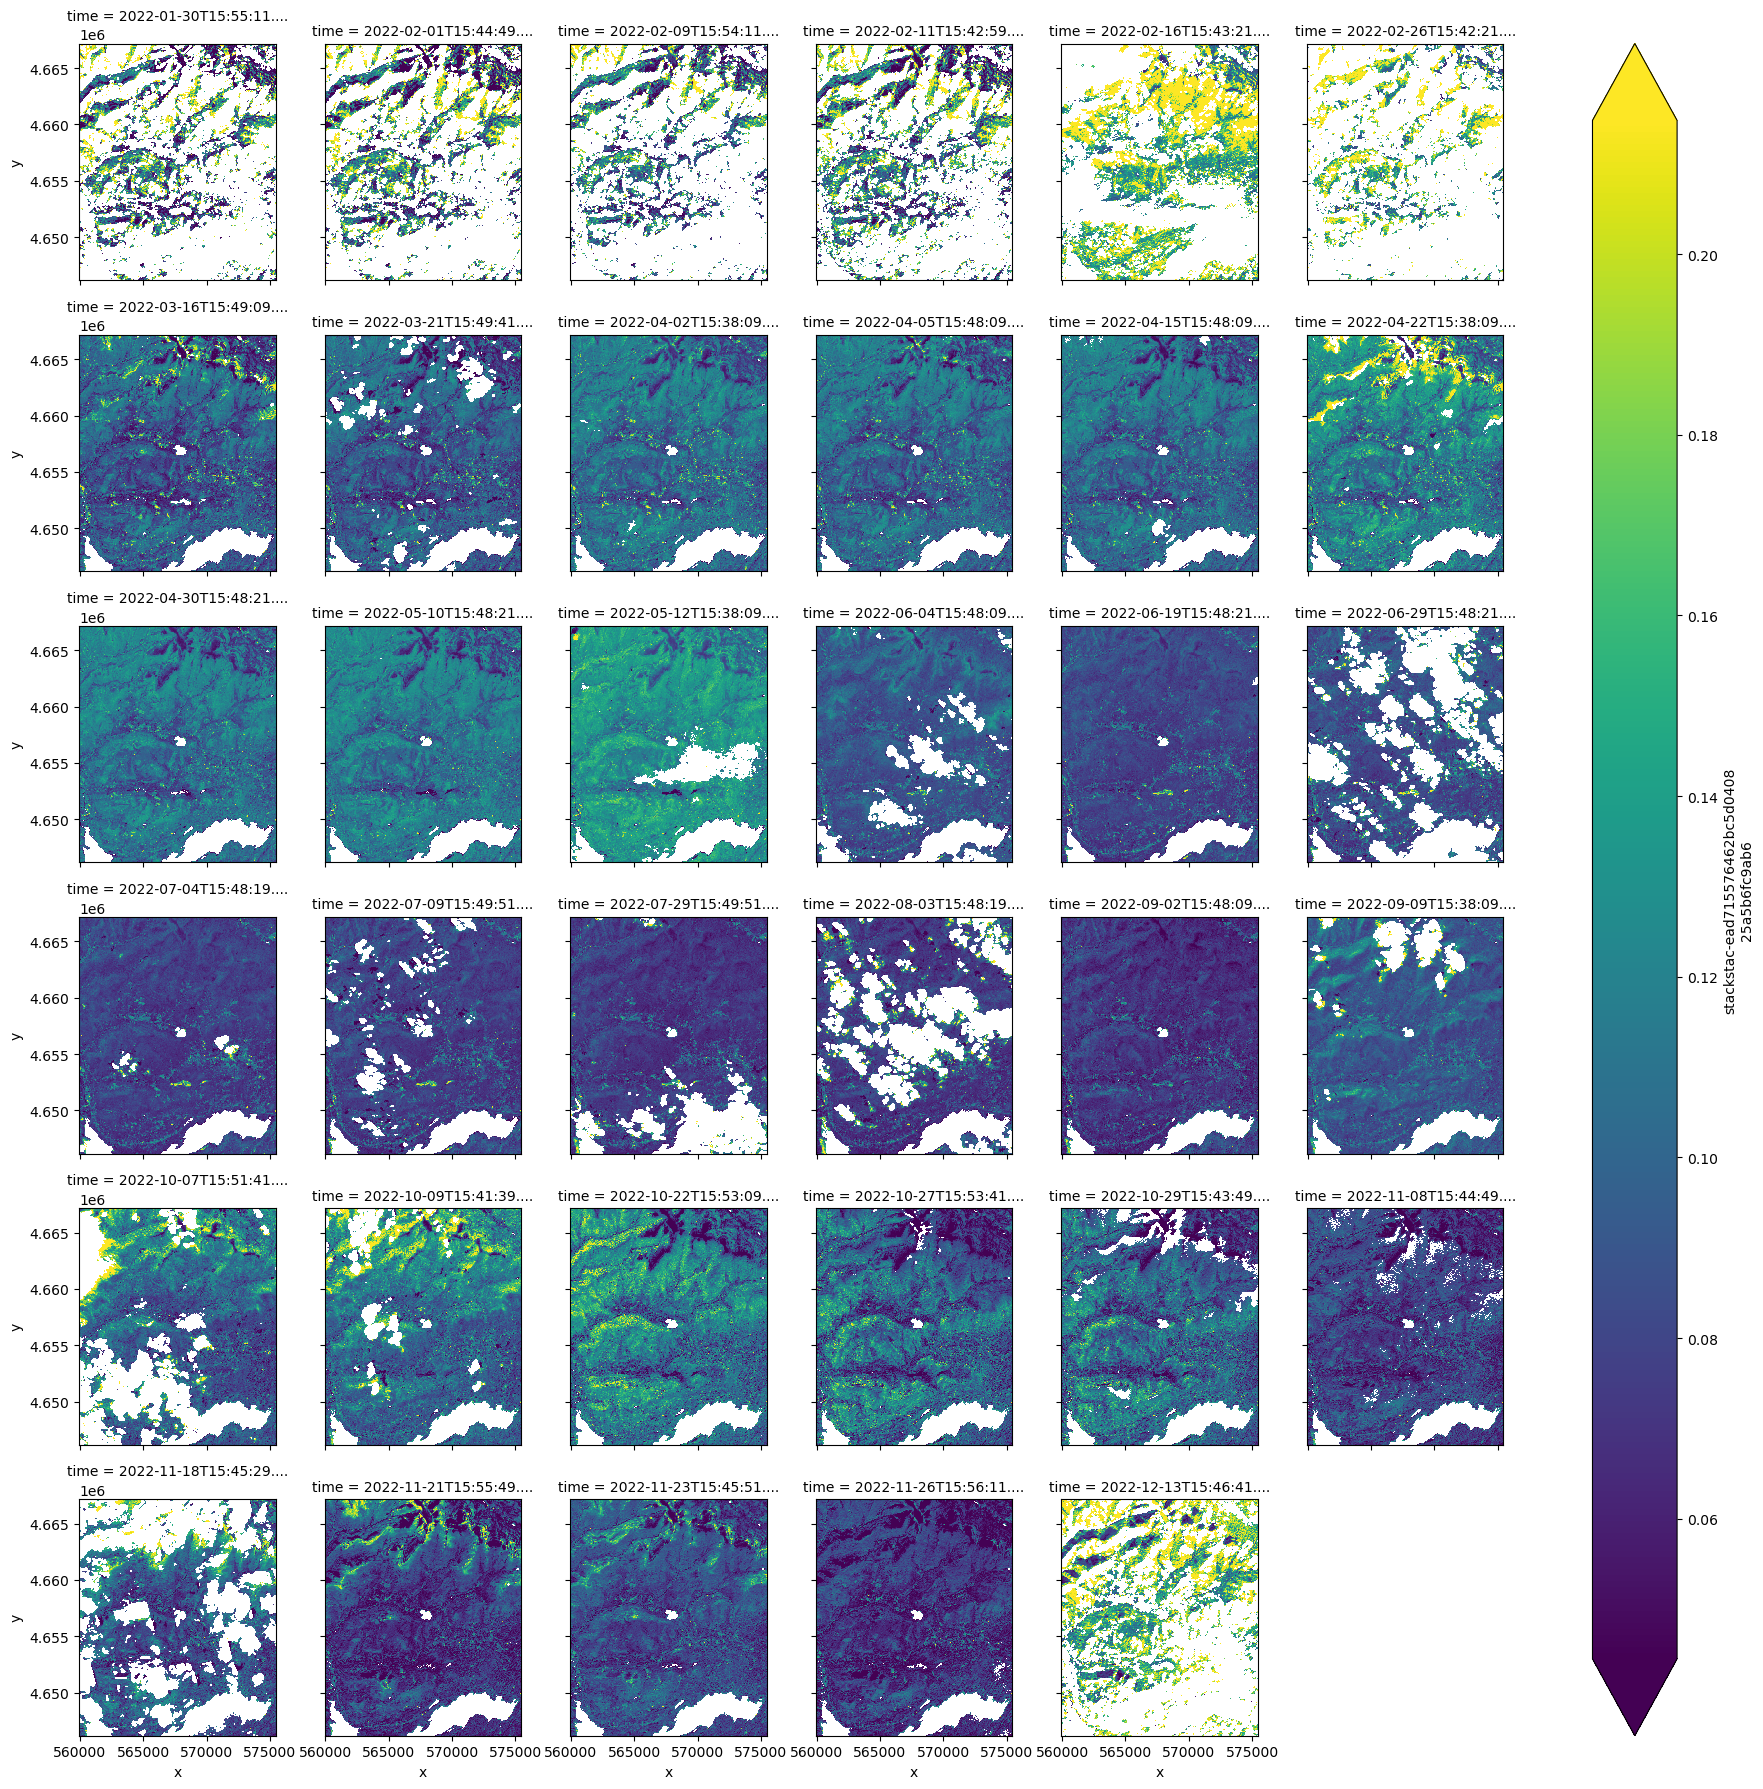

In [6]:
# download and inspect data
roi.download_data(drop='first')
roi.plot_initial_data()

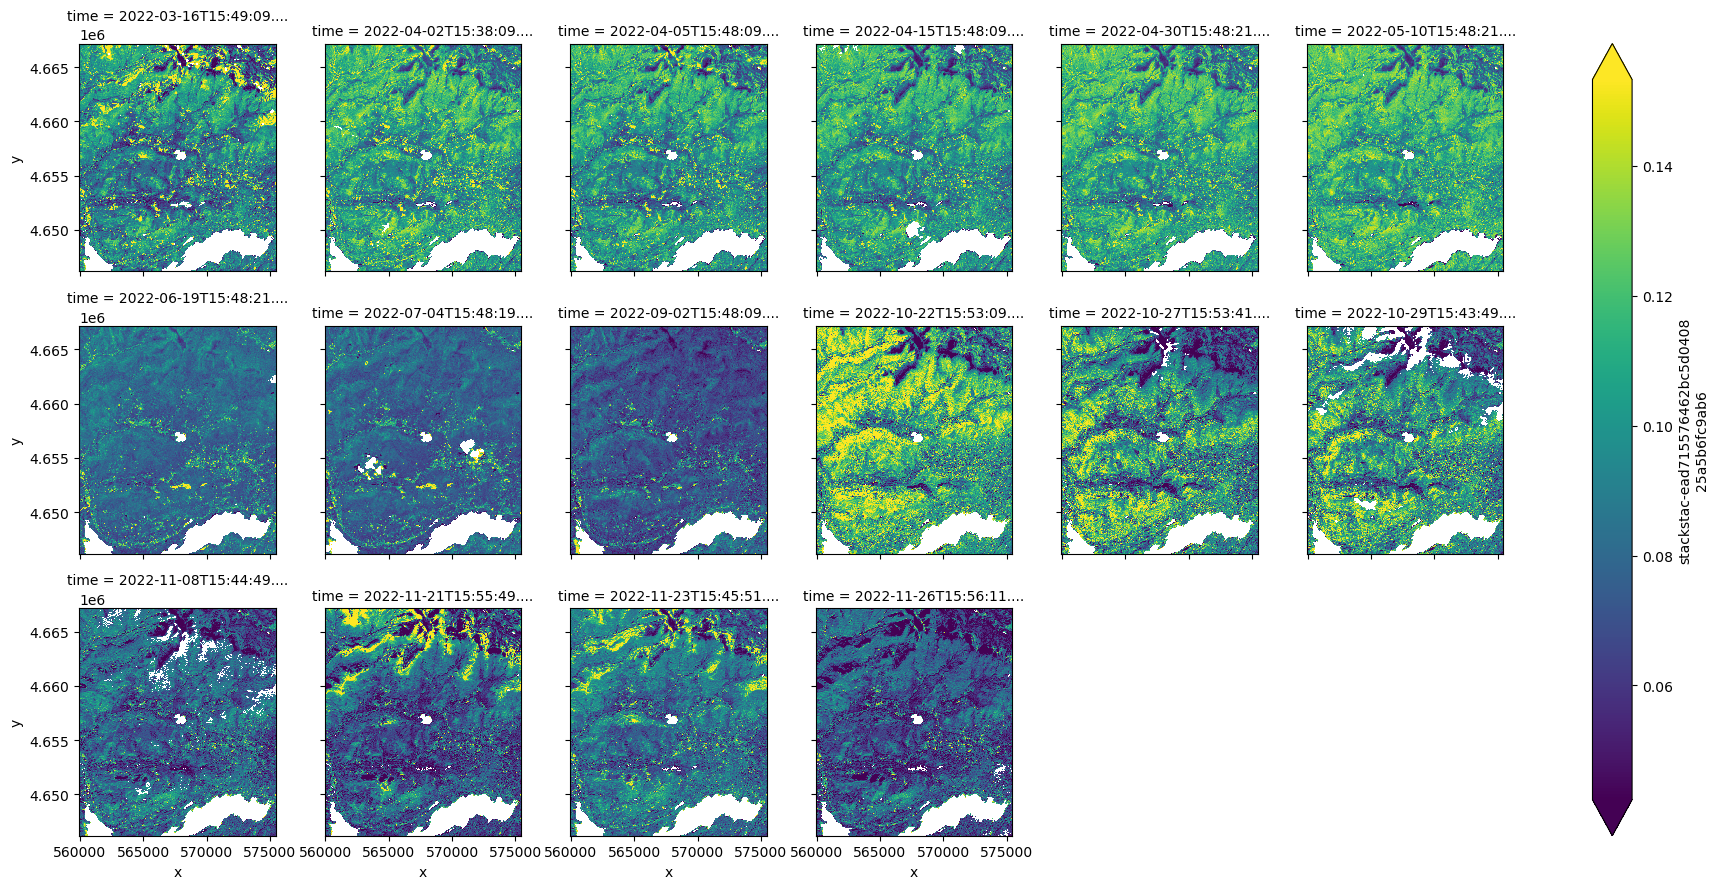

In [7]:
roi.missing_data = [0,1,2,3,4,5,7,11,14,15,17,19,20,21,23,24,25,30,34]
roi.drop_missing_data()
roi.plot_complete_data()

In [8]:
roi.save_bands_data()

In [7]:
# download and inspect Pecoy data
pc = SentinelDownloader(2023,pecoy_buffer,epsg=26918)
#pc.plot_initial_data()

number of low cloud images: 37


In [8]:
# filter out dates with missing data
pc.missing_data = [1,9,19,20,26,28]
pc.drop_missing_data()
#pc.plot_complete_data()

In [9]:
# calculate indices and save
pc.get_indices()
pc.save_vi_data(root,'2023_pecoy')

In [10]:
# download and inspect visitors data
vs = SentinelDownloader(2023,visitors_buffer,epsg=26918)
#vs.plot_initial_data()

number of low cloud images: 37


In [11]:
# filter out missing data, calculate indices and save
vs.missing_data = [19,22,26,27]
vs.drop_missing_data()
vs.get_indices()
vs.save_vi_data(root,'2023_visitors')

### Plot points/polygons overlaid with Sentinel data

C:\Users\roseh\AppData\Local\Temp\ipykernel_13688\2680353202.py:6: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  p = beech_pts.within(roundtop_buffer)


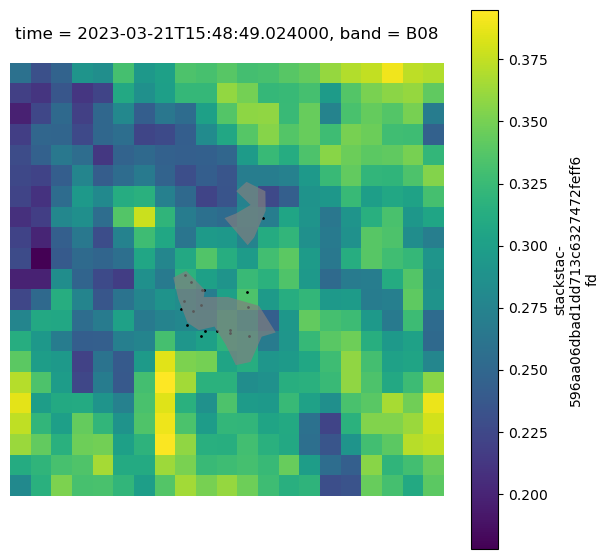

In [ ]:
# select trees within roundtop buffer
points_idx = roundtop_buffer.sindex.query(beech_pts.geometry, predicate="intersects")[0]
roundtop_trees = beech_pts.iloc[points_idx]

# select polygons at roundtop location
rt_polys = polys.iloc[[0,5],:]
rt_polys = rt_polys.to_crs(26918)

# read in roundtop sentinel data
img = xr.open_dataarray(root / 'sentinel_data' / '2023_roundtop.nc')

# plot trees overlaid with sentinel data
fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

im = img.isel(band=6,time=5)
#img = xr.apply_ufunc(exposure.rescale_intensity, img)
p = beech_pts.within(roundtop_buffer)

im.plot.imshow(ax=ax)
roundtop_trees.plot(ax=ax,color='black',markersize=1)
rt_polys.plot(ax=ax,color='grey',alpha=0.7)



ax.set_axis_off()